# Plant Disease Classification Project


### Project Overview


This project focuses on building a machine learning pipeline to classify plant leaves as healthy or diseased. Using deep learning (Convolutional Neural Networks, CNNs), the goal is to accurately predict plant diseases from images of leaves. This pipeline provides the flexibility to train models, evaluate their performance, and make predictions either from image files or directly using a live camera.

The project is particularly useful in agriculture, where early detection of plant diseases can significantly improve crop yields and reduce losses. By automating disease detection, this tool can assist farmers and researchers in identifying issues quickly and effectively.

### Dataset Description

The dataset contains images of plant leaves classified into two main categories:

- Healthy Leaves: Images of leaves without any disease symptoms.
- Diseased Leaves: Images of leaves affected by various diseases.

Each class is represented as a folder in the dataset directory:

Each folder contains images corresponding to a specific disease or healthy leaves.
The images are labeled according to the folder names.


### Dataset Format
- Folders: Each folder represents a class (e.g., "healthy" or "disease_a").
Images: JPEG or PNG files of plant leaves.
Attributes of the Dataset
- Image Size: Images are resized to 128x128 pixels for uniformity and computational efficiency.
- Classes:
Healthy leaves (e.g., "healthy").
Diseased leaves (e.g., "disease_b").


### What the Pipeline Does

The pipeline is designed to perform the following steps:

1. Loading and Visualizing the Dataset
- The load_dataset function loads the images from the dataset directory.
- The images are resized to 128x128 pixels.
- The function displays one image per class for a quick overview of the dataset.

2. Data Preprocessing
- The images are normalized to scale pixel values between 0 and 1.
- Labels are encoded into numerical values using LabelEncoder.
- Data is split into training and testing sets (75% for training, 25% for testing).

3. Model Training

-  Convolutional Neural Network (CNN):

A deep learning model that processes images in their original form.

- The CNN architecture includes convolutional layers, max pooling, dropout, and dense layers.
- The model is trained with early stopping to prevent overfitting.
- Training metrics (accuracy and loss) are visualized.

4. Prediction

The pipeline supports two modes of prediction:

- 1. File Prediction:

- Accepts an image file as input.
- Resizes and normalizes the image before passing it to the trained model.
- Outputs the predicted class and confidence score.

- 2. Live Camera Prediction:

- Opens the webcam for real-time predictions.
- Captures an image when the user presses q.
- Outputs the predicted class and confidence score.

5. Model Evaluation
- Both models are evaluated on the test set.
- Confusion matrices and classification reports are generated for a detailed performance analysis.

### Technologies and Libraries Used

- Python Libraries:
- numpy: For numerical computations.
- matplotlib: For data visualization and plotting confusion matrices.
- cv2: For image processing and accessing the live camera.
- scikit-learn: For Logistic Regression, Random Forest, and evaluation metrics.
- tensorflow: For building and training the CNN model.
- #### Frameworks:
Keras (part of TensorFlow) for deep learning model development.

### Steps in the Jupyter Notebook

1. Dataset Loading and Visualization:

- Understand the structure of the dataset.
- Display one image per class to gain insights into the data.

2. Data Preprocessing:

- Normalize the images.
- Encode the labels and split the data into training and testing sets.

3. Model Training:

- Train CNN model.
- Evaluate models using confusion matrices and classification reports.
- Retrains the model once a new dataset is uploaded after making predictions and updates the model and label encoder

4. Visualization:

- Plot training metrics (accuracy and loss) for the CNN model.
- Generate confusion matrices for both models.

5. Prediction:

- Make predictions using test images or live camera input.
- Output predicted classes with confidence scores.


### Example Applications

- Early detection of plant diseases to improve agricultural practices.
- Assisting researchers in studying disease patterns in plants.


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import ConfusionMatrixDisplay

In [8]:

# Load Dataset
def load_dataset(dataset_path, image_size=(128, 128)):
    data = []
    labels = []

    
    all_classes = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

    # Separate healthy and disease classes
    disease_classes = [cls for cls in all_classes if "healthy" not in cls.lower()]
    healthy_classes = [cls for cls in all_classes if "healthy" in cls.lower()]

    print(f"Selected disease classes: {disease_classes}")
    print(f"Selected healthy classes: {healthy_classes}")

    for class_name in disease_classes + healthy_classes:
        class_dir = os.path.join(dataset_path, class_name)
        class_images = [os.path.join(class_dir, img_name) for img_name in os.listdir(class_dir)]

        for img_path in class_images:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Unable to load image: {img_path}")
                continue

            # Resize and add to dataset
            image = cv2.resize(image, image_size)
            data.append(image)
            labels.append(class_name)

    print(f"\nLoaded {len(data)} images.")
    return np.array(data), np.array(labels), disease_classes + healthy_classes


In [9]:
# Preprocess Dataset
def preprocess_data(data, labels):
    data = data.astype('float32') / 255.0  # Normalize
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return data, encoded_labels, label_encoder


In [12]:
# Build CNN model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [13]:
# Train CNN Model
def train_cnn(data, labels, model_save_path=None, label_encoder_path=None):
    # Preprocess Data
    data, encoded_labels, label_encoder = preprocess_data(data, labels)
    num_classes = len(np.unique(encoded_labels))
    X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.25, stratify=encoded_labels)

    # Convert to categorical
    y_train_onehot = to_categorical(y_train, num_classes=num_classes)
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)

    # Build model
    model = build_cnn(X_train.shape[1:], num_classes)

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
    history = model.fit(
        X_train, y_train_onehot,
        validation_data=(X_test, y_test_onehot),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping]
    )

    # Evaluate Model
    predictions = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"CNN Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions, target_names=label_encoder.classes_))

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    plt.figure(figsize=(12, 12))
    disp.plot(cmap=plt.cm.Blues, colorbar=True)
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Save the model
    if model_save_path:
        model.save(model_save_path)
    
    # Save the label encoder
    if label_encoder_path:
        joblib.dump(label_encoder, label_encoder_path)
        print(f"Label encoder saved to: {label_encoder_path}")
    
    return model, label_encoder


In [14]:
def predict_from_file(model, label_encoder, image_path, dataset_path, model_save_path, label_encoder_path):
    print("\n### Predicting from File ###")
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to read the image file.")
        return
    image_resized = cv2.resize(image, (128, 128)) / 255.0
    probabilities = model.predict(image_resized.reshape(1, 128, 128, 3))[0]
    predicted_class = label_encoder.inverse_transform([np.argmax(probabilities)])[0]
    confidence = np.max(probabilities) * 100
    print(f"Prediction: {predicted_class} | Confidence: {confidence:.2f}%")

    # Append the image to the dataset
    class_dir = os.path.join(dataset_path, predicted_class)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)
    save_path = os.path.join(class_dir, os.path.basename(image_path))
    cv2.imwrite(save_path, image)
    print(f"Image saved to class directory: {class_dir}")

    # Retrain the model with the updated dataset
    print("\nRetraining the model with the updated dataset...")
    data, labels, _ = load_dataset(dataset_path)
    cnn_model, label_encoder = train_cnn(
        data, labels, model_save_path=model_save_path, label_encoder_path=label_encoder_path
    )
    print("Model retrained and updated successfully.")


In [15]:
def predict_from_camera(model, label_encoder, dataset_path, model_save_path, label_encoder_path):
    print("\n### Predicting from Live Camera ###")
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Unable to access the camera.")
        return
    print("Press 'q' to capture an image and make a prediction.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Unable to read from the camera.")
            break

        cv2.imshow("Live Camera - Press 'q' to Capture", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            image_resized = cv2.resize(frame, (128, 128)) / 255.0
            probabilities = model.predict(image_resized.reshape(1, 128, 128, 3))[0]
            predicted_class = label_encoder.inverse_transform([np.argmax(probabilities)])[0]
            confidence = np.max(probabilities) * 100
            print(f"Prediction: {predicted_class} | Confidence: {confidence:.2f}%")

            # Save the image to the appropriate class folder
            class_dir = os.path.join(dataset_path, predicted_class)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            save_path = os.path.join(class_dir, "captured_image.jpg")
            cv2.imwrite(save_path, frame)
            print(f"Image saved to class directory: {class_dir}")

            # Retrain the model with the updated dataset
            print("\nRetraining the model with the updated dataset...")
            data, labels, _ = load_dataset(dataset_path)
            cnn_model, label_encoder = train_cnn(
                data, labels, model_save_path=model_save_path, label_encoder_path=label_encoder_path
            )
            print("Model retrained and updated successfully.")
            break


Selected disease classes: ['Pepper__bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Selected healthy classes: ['Pepper__bell___healthy', 'Potato___healthy', 'Tomato_healthy']

Loaded 20638 images.


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 206s 412ms/step - accuracy: 0.4033 - loss: 1.8742 - val_accuracy: 0.7391 - val_loss: 0.7843
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 148s 305ms/step - accuracy: 0.7327 - loss: 0.8174 - val_accuracy: 0.8419 - val_loss: 0.4644
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 150s 309ms/step - accuracy: 0.8129 - loss: 0.5575 - val_accuracy: 0.8312 - val_loss: 0.4884
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 139s 288ms/step - accuracy: 0.8524 - loss: 0.4489 - val_accuracy: 0.8678 - val_loss: 0.3838
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 132s 272ms/step - accuracy: 0.8810 - loss: 0.3549 - val_accuracy: 0.8986 - val_loss: 0.2963
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 139s 287ms/step - accuracy: 0.9037 - loss: 0.2900 - val_accuracy: 0.9052 - val_loss: 0.2659
Epoch 7/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 154s 318ms/step - accuracy: 0.9144 - loss: 0.2506 - val_accuracy: 0.8996 - val_loss: 0.2780
Epoch 8/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 143s 296ms/step - accuracy: 0.9326 -

<Figure size 1200x1200 with 0 Axes>

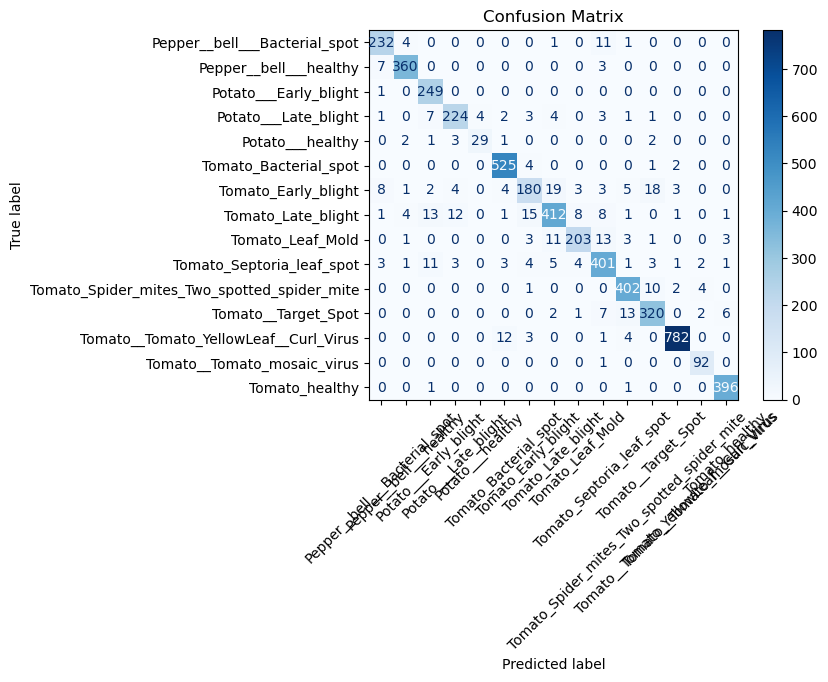

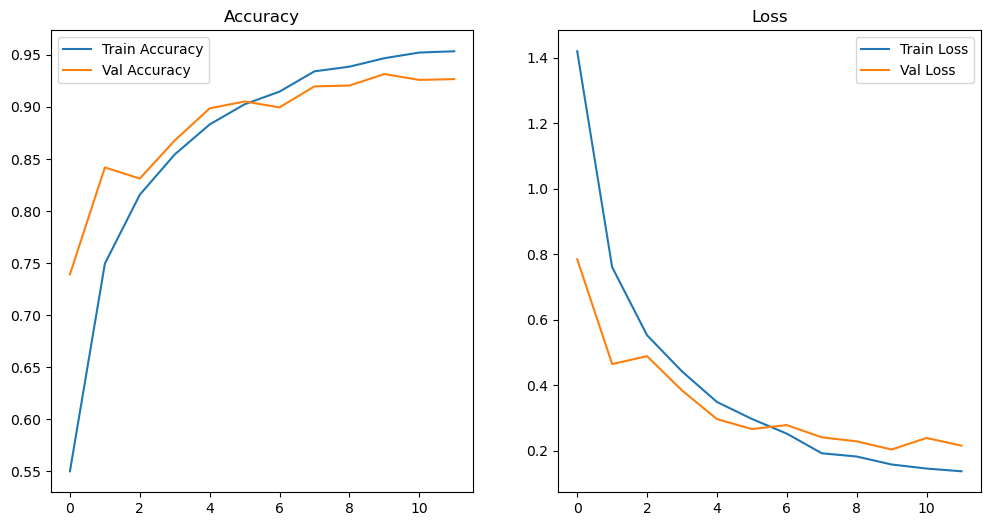

Label encoder saved to: C:\Users\hp\OneDrive\Desktop\Plants_Disease_Classifier_MLOP\models\label_encoder.pkl

### Predicting from File ###
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Prediction: Tomato_Late_blight | Confidence: 99.98%
Image saved to class directory: C:\Users\hp\OneDrive\Desktop\Plants_Disease_Classifier_MLOP\dataset\Tomato_Late_blight

Retraining the model with the updated dataset...
Selected disease classes: ['Pepper__bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Selected healthy classes: ['Pepper__bell___healthy', 'Potato___healthy', 'Tomato_healthy']

Loaded 20639 images.


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 198s 386ms/step - accuracy: 0.3533 - loss: 2.0056 - val_accuracy: 0.7457 - val_loss: 0.7922
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 142s 292ms/step - accuracy: 0.6953 - loss: 0.9281 - val_accuracy: 0.8103 - val_loss: 0.5807
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 139s 286ms/step - accuracy: 0.7790 - loss: 0.6669 - val_accuracy: 0.8612 - val_loss: 0.4153
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 129s 266ms/step - accuracy: 0.8205 - loss: 0.5240 - val_accuracy: 0.8756 - val_loss: 0.3708
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 169s 348ms/step - accuracy: 0.8591 - loss: 0.4181 - val_accuracy: 0.8953 - val_loss: 0.3058
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 143s 294ms/step - accuracy: 0.8810 - loss: 0.3633 - val_accuracy: 0.9037 - val_loss: 0.2814
Epoch 7/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 155s 320ms/step - accuracy: 0.9065 - loss: 0.2878 - val_accuracy: 0.9236 - val_loss: 0.2230
Epoch 8/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 128s 264ms/step - accuracy: 0.9156 -

<Figure size 1200x1200 with 0 Axes>

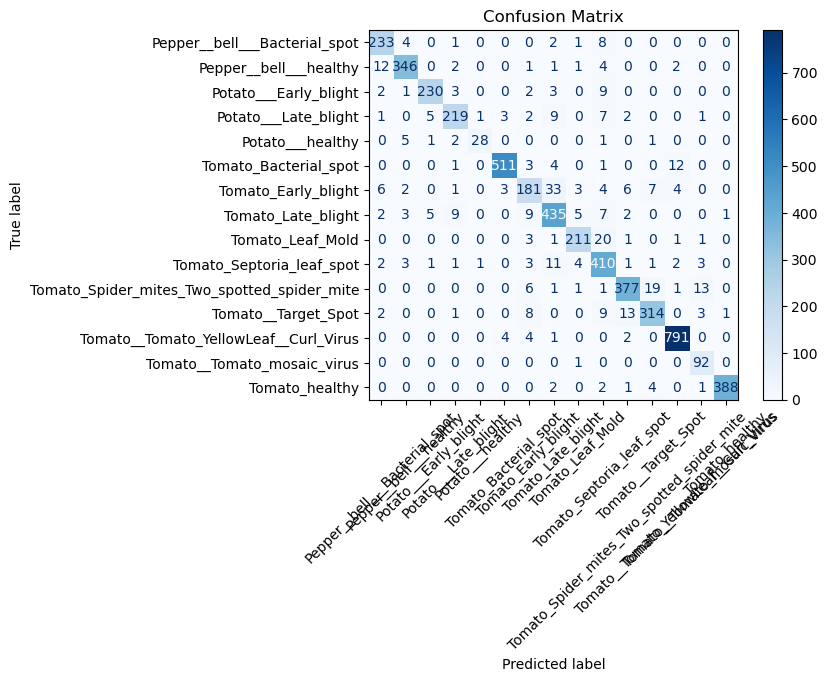

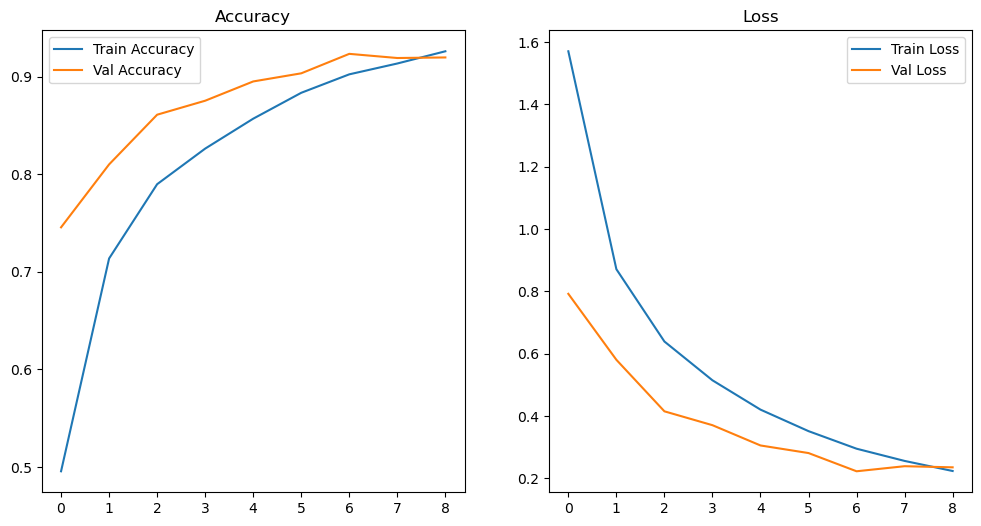

Label encoder saved to: C:\Users\hp\OneDrive\Desktop\Plants_Disease_Classifier_MLOP\models\label_encoder.pkl
Model retrained and updated successfully.


In [16]:
if __name__ == "__main__":
    dataset_path = r"C:\Users\hp\OneDrive\Desktop\Plants_Disease_Classifier_MLOP\dataset"
    model_save_path = r"C:\Users\hp\OneDrive\Desktop\Plants_Disease_Classifier_MLOP\models\cnn_model.h5"
    label_encoder_path = r"C:\Users\hp\OneDrive\Desktop\Plants_Disease_Classifier_MLOP\models\label_encoder.pkl"
    test_image_path = r"C:\Users\hp\Downloads\test_leaf.jpg"

    # Load dataset
    data, labels, _ = load_dataset(dataset_path)

    # Train model and save label encoder
    cnn_model, label_encoder = train_cnn(
        data, labels, model_save_path=model_save_path, label_encoder_path=label_encoder_path
    )

    # Predict from a test image and update the model
    predict_from_file(
        cnn_model, label_encoder, test_image_path, dataset_path, model_save_path, label_encoder_path
    )

#     # Predict from live camera and update the model
#     predict_from_camera(
#         cnn_model, label_encoder, dataset_path, model_save_path, label_encoder_path
#     )

